In [1]:
from anova import global_hpi, local_hpi
import json
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font

In [18]:
SEARCH_SPACE = {
    "bpe": [1000.0, 2000.0, 4000.0, 8000.0, 16000.0, 32000.0],
    "n_layers": [1.0, 2.0, 4.0],
    "n_embed": [256.0, 512.0, 1024.0],
    "n_hidden": [1024.0, 2048.0],
    "n_heads": [8.0, 16.0],
    "initial_lr": [0.0003, 0.0006, 0.001],
}

hp_names = [
    "bpe",
    "n_layers",
    "n_embed",
    "n_hidden",
    "n_heads",
    "initial_lr",
]
obj_name = "bleu"

data = {
    k: np.asarray([SEARCH_SPACE[k].index(val) for val in v]) if k in hp_names
    else np.asarray(v)
    for k, v in json.load(open("nmt-bench/so-en.json")).items()
    if k in hp_names + [obj_name]
}
bounds = {k: (data[k].min(), data[k].max()) for k in hp_names}
order = np.argsort(-data[obj_name])
const_vals = dict(
    param_names=hp_names,
    obj_name=obj_name,
    bounds=bounds,
    minimize=False,
    n_samples=10000,
    seed=42,
)
bounds

{'bpe': (0, 5),
 'n_layers': (0, 2),
 'n_embed': (0, 2),
 'n_hidden': (0, 1),
 'n_heads': (0, 1),
 'initial_lr': (0, 2)}

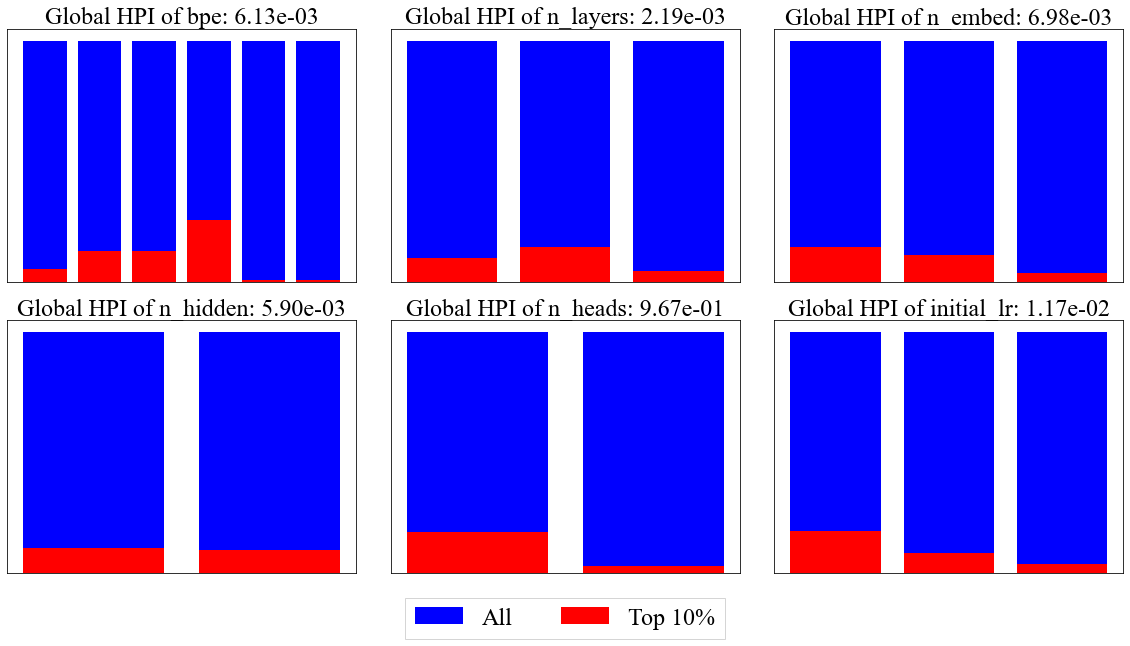

In [65]:
gamma = 0.1
g_hpi = global_hpi(
    observations=data,
    gamma=gamma,
    **const_vals
)
total_hpi = sum(v for v in g_hpi.values())

R, C = 2, 3
TICK_PARAMS = dict(
    labelleft=False,
    labelbottom=False,
    left=False,
    bottom=False,
)
_, axes = plt.subplots(
    ncols=C,
    nrows=R,
    figsize=(20, 10),
    gridspec_kw=dict(
        wspace=0.1,
        hspace=0.15,
    )
)

N = data[obj_name].size
lines = []
for idx, hp_name in enumerate(hp_names):
    r, c = idx // C, idx % C
    ax = axes[r][c]
    ax.tick_params(**TICK_PARAMS)
    choices = np.arange(bounds[hp_name][-1] + 1)
    _, counts = np.unique(data[hp_name], return_counts=True)
    line = ax.bar(choices, counts, color="blue")
    if idx == 5:
        lines.append(line)

    top_data = data[hp_name][order[:int(gamma * N)]]
    vals, counts = np.unique(top_data, return_counts=True)
    counts = np.array([counts[vals == c][0] if c in vals else 0 for c in choices])
    line = ax.bar(choices, counts, color="red")
    if idx == 5:
        lines.append(line)

    ax.set_title(f"Global HPI of {hp_name}: {g_hpi[hp_name]/total_hpi:.2e}", fontsize=24)
else:
    axes[1][1].legend(
        handles=lines,
        labels=["All", "Top 10%"],
        loc='upper center',
        fontsize=24,
        bbox_to_anchor=(0.5, -0.05),  # ここは調整が必要です
        fancybox=False,
        shadow=False,
        ncol=2,
    )

plt.savefig("figs/nmt-global-hpi.png", bbox_inches="tight")

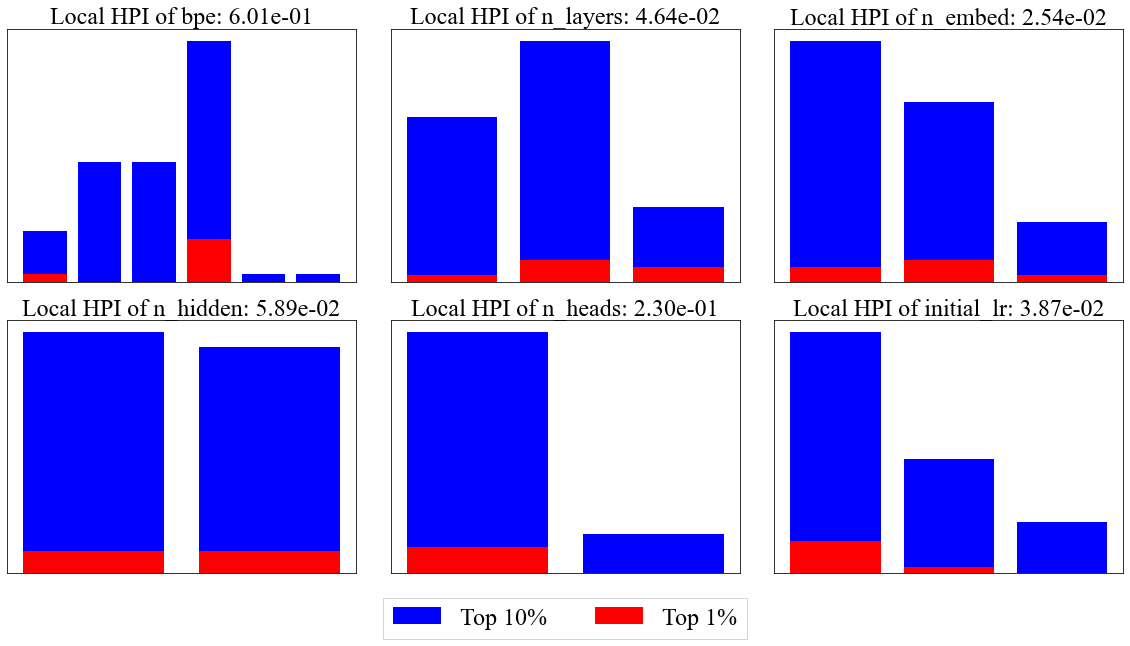

In [66]:
gamma_local = 0.1
gamma_local_top = 0.01
l_hpi = local_hpi(
    observations=data,
    gamma_local=gamma_local,
    gamma_local_top=gamma_local_top,
    **const_vals
)
total_hpi = sum(v for v in l_hpi.values())

_, axes = plt.subplots(
    ncols=C,
    nrows=R,
    figsize=(20, 10),
    gridspec_kw=dict(
        wspace=0.1,
        hspace=0.15,
    )
)

lines = []
for idx, hp_name in enumerate(hp_names):
    r, c = idx // C, idx % C
    ax = axes[r][c]
    ax.tick_params(**TICK_PARAMS)
    choices = np.arange(bounds[hp_name][-1] + 1)
    top_data = data[hp_name][order[:int(gamma_local * N)]]
    vals, counts = np.unique(top_data, return_counts=True)
    counts = np.array([counts[vals == c][0] if c in vals else 0 for c in choices])
    line = ax.bar(choices, counts, color="blue")
    if idx == 5:
        lines.append(line)

    top_data = data[hp_name][order[:int(gamma_local_top * N)]]
    vals, counts = np.unique(top_data, return_counts=True)
    counts = np.array([counts[vals == c][0] if c in vals else 0 for c in choices])
    line = ax.bar(choices, counts, color="red")
    if idx == 5:
        lines.append(line)

    ax.set_title(f"Local HPI of {hp_name}: {l_hpi[hp_name]/total_hpi:.2e}", fontsize=24)
else:
    axes[1][1].legend(
        handles=lines,
        labels=["Top 10%", "Top 1%"],
        loc='upper center',
        fontsize=24,
        bbox_to_anchor=(0.5, -0.05),  # ここは調整が必要です
        fancybox=False,
        shadow=False,
        ncol=2,
    )

plt.savefig("figs/nmt-local-hpi.png", bbox_inches="tight")

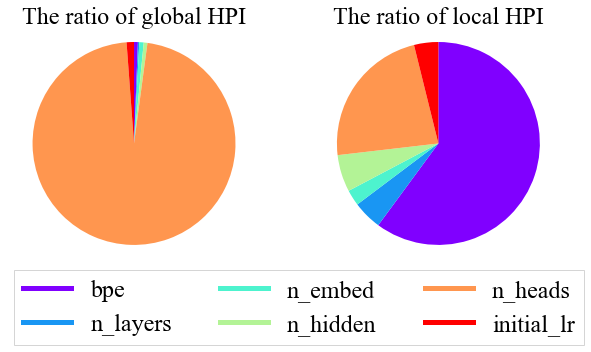

In [67]:
fig, axes = plt.subplots(
    ncols=2,
    figsize=(10, 5),
)

ZEROS = np.zeros(2)
lines = [
    ax.plot(
        ZEROS, ZEROS, ZEROS, color=color, label=hp_name, lw=5,
    )[0]
    for color, hp_name in zip(colors, g_hpi.keys())
]

cm = plt.get_cmap("rainbow")
colors = [cm(i/5) for i in range(6)]
pie_kwargs = dict(
    colors=colors,
    startangle=90,
    counterclock=False,
    textprops={"fontsize": 24}
)

g_hpi_vals = [v for v in g_hpi.values()]
g_hpi_vals /= np.sum(g_hpi_vals)
g_hpi_vals *= 100

ax = axes[0]
ax.set_title("The ratio of global HPI", fontsize=24, y=0.95)
ax.pie(g_hpi_vals, **pie_kwargs)

l_hpi_vals = [v for v in l_hpi.values()]
l_hpi_vals /= np.sum(l_hpi_vals)
l_hpi_vals *= 100

ax = axes[1]
ax.set_title("The ratio of local HPI", fontsize=24, y=0.95)
ax.pie(l_hpi_vals, **pie_kwargs)

axes[1].legend(
    handles=lines,
    labels=list(g_hpi.keys()),
    loc='upper center',
    fontsize=24,
    bbox_to_anchor=(-0.05, 0.05),  # ここは調整が必要です
    fancybox=False,
    shadow=False,
    ncol=3,
)

plt.savefig("figs/nmt-hpi-ratio.png", bbox_inches="tight")